In [1]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
%matplotlib inline

# Extraction, Model and Data Loading custom classes

In [2]:
def get_label(dir_name):
    return dir_name.split(' ')[0]

class Fruits360Dataset(ImageFolder):
    def find_classes(self, directory):
        dirs = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        dirs_to_classes = {cls_name: get_label(cls_name) for cls_name in dirs}
        classes = set(dirs_to_classes.values())
        classes_to_indices = {c: i for i, c in enumerate(classes)}
        class_to_idx = {d: classes_to_indices[dirs_to_classes[d]] for d in dirs}
        return classes, class_to_idx

In [3]:
class DeviceLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [4]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [5]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 2096)
        self.hidden1 = nn.Linear(2096, 1048)
        self.hidden2 = nn.Linear(1048, 524)
        self.linear2 = nn.Linear(524, output_size)
        
    def forward(self, x):
        out1 = self.linear1(x.view(x.size(0), -1))
        out2 = self.hidden1(F.relu(out1))
        out3 = self.hidden2(F.relu(out2))
        return self.linear2(F.relu(out3))
    
    def step(self, batch, sample_type):
        images, labels = batch 
        out = self(images)                   
        loss = F.cross_entropy(out, labels)   
        _, preds = torch.max(out, dim=1)
        acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
        return loss, {f'{sample_type}_loss': loss.detach(), f'{sample_type}_accuracy': acc}

    def training_epoch_end(self, outputs):
        batch_accuracies = [x['training_accuracy'] for x in outputs]
        epoch_accuracies = torch.stack(batch_accuracies).mean()
        batch_losses = [x['training_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'training_accuracy': epoch_accuracies.item(), 'training_loss': epoch_loss.item()}
        
    def validation_epoch_end(self, outputs):
        batch_accuracies = [x['validation_accuracy'] for x in outputs]
        epoch_accuracies = torch.stack(batch_accuracies).mean()
        batch_losses = [x['validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'validation_accuracy': epoch_accuracies.item(), 'validation_loss': epoch_loss.item()}
    
    def fit(self, epochs, learning_rate, model, train_loader, validation_loader, opt_func=torch.optim.SGD):
        training_results = []
        validation_results = []
        optimizer = opt_func(model.parameters(), learning_rate)
        for epoch in range(epochs):
            training_outputs = []
            for batch in train_loader:
                loss, training_output = model.step(batch, 'training')
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                training_outputs.append(training_output)
                
            training_result = model.training_epoch_end(training_outputs)
            training_results.append(training_result)
            validation_outputs = [model.step(batch, 'validation')[1] for batch in validation_loader]
            validation_result = model.validation_epoch_end(validation_outputs)
            validation_results.append(validation_result)
            
        return training_results, validation_results

In [6]:
def plot_results(x, label='Results', text=''):
    plt.plot(x, '-x')
    plt.xlabel('epoch')
    plt.ylabel(f'{label}')
    plt.title(f'{label} vs. No. of epochs {text}');

# Extract Data, Fitting and Results

In [8]:
dataset = Fruits360Dataset("./fruits-360/Training", transform=ToTensor())
test = Fruits360Dataset("./fruits-360/Test", transform=ToTensor())
len(dataset), len(test)

(67699, 22688)

In [9]:
validation_size = int(len(dataset) * 0.1)
train_size = len(dataset) - validation_size

In [10]:
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
len(train_dataset), len(validation_dataset)

(60930, 6769)

In [11]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size*4, num_workers=2, pin_memory=True)
test_loader = DataLoader(test, batch_size*4, num_workers=2, pin_memory=True)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
device = get_device()
train_loader = DeviceLoader(train_loader, device)
validation_loader = DeviceLoader(validation_loader, device)
test_loader = DeviceLoader(test_loader, device)

In [13]:
input_size = np.prod(np.array(dataset[0][0].shape)) # 3*100*100
output_size = len(dataset.find_classes("./fruits-360/Training")[0]) # 67 classes

In [14]:
model = to_device(Model(input_size, output_size), device)

[{'validation_accuracy': 0.00977010652422905,
  'validation_loss': 4.211748123168945}]

In [15]:
# training_results, validation_results = model.fit(10, 0.05, model, train_loader, validation_loader)

In [16]:
# training_results1, validation_results1 = model.fit(10, 0.02, model, train_loader, validation_loader)

In [ ]:
training_results2, validation_results2 = model.fit(10, 0.001, model, train_loader, validation_loader)

In [22]:
validation_results2

[{'validation_accuracy': 0.09243639558553696,
  'validation_loss': 3.903703212738037},
 {'validation_accuracy': 0.10321922600269318,
  'validation_loss': 3.7652618885040283},
 {'validation_accuracy': 0.1708008050918579,
  'validation_loss': 3.614274024963379},
 {'validation_accuracy': 0.17629849910736084,
  'validation_loss': 3.426072359085083},
 {'validation_accuracy': 0.18588551878929138,
  'validation_loss': 3.2494866847991943},
 {'validation_accuracy': 0.18654105067253113,
  'validation_loss': 3.0606348514556885},
 {'validation_accuracy': 0.2196129411458969,
  'validation_loss': 2.83864688873291},
 {'validation_accuracy': 0.2695261240005493,
  'validation_loss': 2.622375726699829},
 {'validation_accuracy': 0.28761959075927734,
  'validation_loss': 2.4010889530181885},
 {'validation_accuracy': 0.23701246082782745,
  'validation_loss': 2.6183526515960693}]

In [30]:
training_accuracies = [x['training_accuracy'] for x in training_results2]
training_losses = [x['training_loss'] for x in training_results2]

In [31]:
validation_accuracies = [x['validation_accuracy'] for x in validation_results2]
validation_losses = [x['validation_loss'] for x in validation_results2]

Text(0.5, 1.0, 'Accuracy')

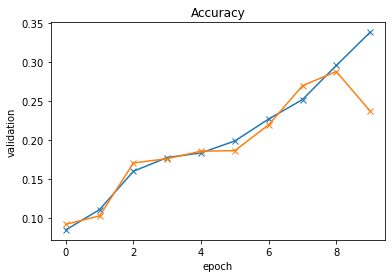

In [32]:
plot_results(training_accuracies, label = 'train')
plot_results(validation_accuracies, label = 'validation')
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

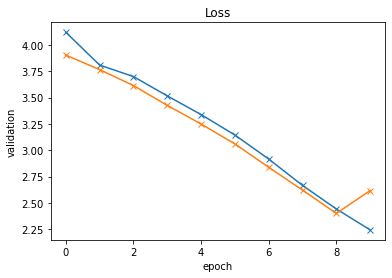

In [33]:
plot_results(training_losses, label = 'train')
plot_results(validation_losses, label = 'validation')
plt.title('Loss')